In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
#!wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#    -O /tmp/sunspots.csv

In [4]:
root = r'D:\Users\Arkady\Verint\Coursera_2019_Tensorflow_Specialization\Course4_Sequences_TimeSeries_Prediction'

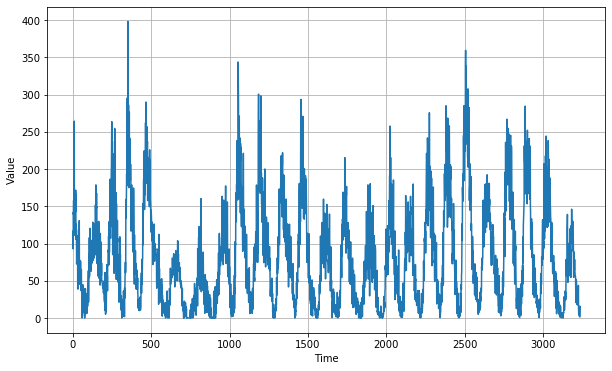

In [5]:
import csv
time_step = []
sunspots = []

with open(root + '/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

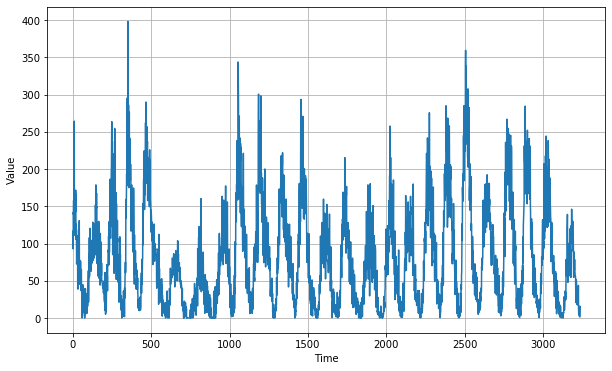

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 559ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 3s 227ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 3s 225ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 3s 229ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 3s 242ms/step - loss: 68.5302 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 3s 252ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 3s 253ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 3s 228ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 3s 231ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/

[1e-08, 0.0001, 0, 60]

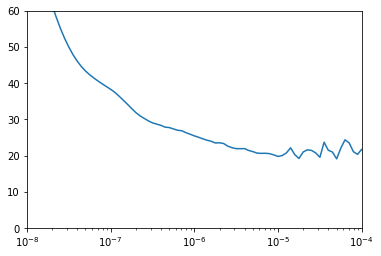

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 6s 215ms/step - loss: 37.8896 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 3s 110ms/step - loss: 24.1464 - mae: 24.6110
Epoch 3/500
30/30 [==============================] - 3s 111ms/step - loss: 22.0333 - mae: 22.5253
Epoch 4/500
30/30 [==============================] - 3s 107ms/step - loss: 19.8071 - mae: 20.3066
Epoch 5/500
30/30 [==============================] - 3s 105ms/step - loss: 19.4317 - mae: 19.9259
Epoch 6/500
30/30 [==============================] - 3s 106ms/step - loss: 19.3082 - mae: 19.7959
Epoch 7/500
30/30 [==============================] - 3s 108ms/step - loss: 19.1645 - mae: 19.6468
Epoch 8/500
30/30 [==============================] - 3s 106ms/step - loss: 18.4127 - mae: 18.8916
Epoch 9/500
30/30 [==============================] - 3s 107ms/step - loss: 18.3207 - mae: 18.8271
Epoch 10/500
30/30 [==============================] - 3s 105ms/step - loss: 18.1137 - mae: 18.6407
Epoch 11/500
30/30 

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

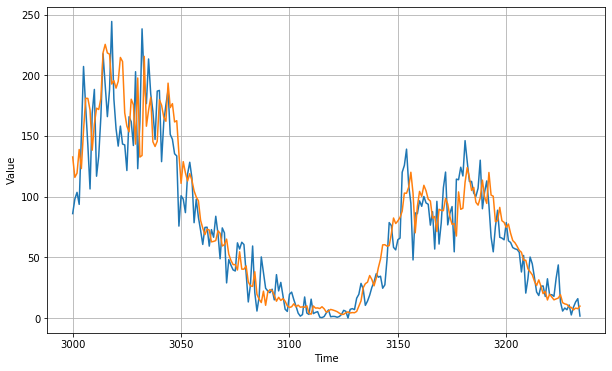

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.555782

<Figure size 432x288 with 0 Axes>

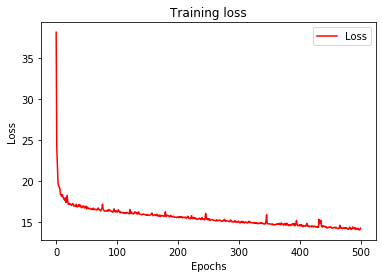

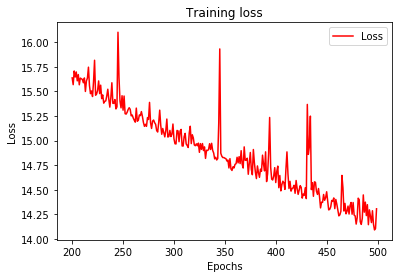

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[132.6621    115.83048   119.30589   138.8124    123.133644  154.33026
 181.03398   180.90062   171.43964   138.20264   159.68742   172.85323
 171.7591    180.72061   218.50526   225.4367    218.38116   217.37556
 192.74423   195.5323    189.37007   194.97612   214.65904   211.28874
 169.01088   158.09024   153.38425   180.22993   175.67513   143.26187
 197.71634   132.5853    133.88084   215.56345   157.99385   171.08528
 181.64545   145.18005   141.29713   145.61307   179.75723   175.28375
 165.62105   162.06798   193.47801   173.31953   176.60147   161.5033
 162.54701   135.40424   110.91272   128.79305   119.588875  112.837814
 118.87052   113.4617    104.70977    99.67482    96.48145    80.4334
  74.01068    68.675186   73.1566     72.466385   62.700348   63.104652
  63.752533   71.783005   69.82916    59.28725    60.43396    64.9702
  52.535397   47.441395   43.957035   43.975807   39.546646   54.541718
  40.24673    40.202267   42.875904   29.636425   26.463581   26.040741
  38.